<a href="https://colab.research.google.com/github/Yustira/ANN-MT-1D/blob/main/Inversi_MT_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install SimPEG==0.11.6
!pip install git+https://github.com/simpeg/tle-magnetotelluric_inversion
!pip install pymatsolver==0.1.3

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from scipy.constants import mu_0
from SimPEG import (Mesh, Maps, SolverLU, 
                    DataMisfit, Regularization,
                    Optimization, InvProblem, Inversion, 
                    Directives, Utils)
try: 
    from pymatsolver import PardisoSolver as Solver
except importError:
    from SimPEG import SolverLU as SolverLU

from tleMT.MT1D import MT1DProblem, MT1DSurvey, MT1DSrc, ZxyRx, Survey, AppResPhaRx
%matplotlib inline

In [ ]:
def open_data(loc_file):
    period = []
    rho = []
    phi = []

    with open(loc_file) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            period.append(float(row[0]))
            rho.append(float(row[1]))
            phi.append(float(row[2]))

    period = np.array(period)
    rho = np.array(rho)
    phi = np.array(phi)
        
    return period, rho, phi

In [ ]:
def model_forecast(model, series):
    forecast = []
    for i in range(len(series)-window_size):
        forecast.append(model.predict(series[i:i+window_size][np.newaxis]))
    forecast = np.array(forecast)[:, 0, 0]
    return forecast

In [ ]:
def build_mesh(frequency, max_depth_core, ncell_per_skind=1e2, 
               n_skind=2, max_hz_core=5e1):
    rxloc = np.r_[0]
    rx = ZxyRx(rxloc, component='both', frequency=frequency)
    src = MT1DSrc([rx])
    survey = MT1DSurvey([src])
    max_depth_core = max_depth_core
    mesh = survey.setMesh(sigma=1e-2, max_depth_core=max_depth_core,
                          ncell_per_skind=ncell_per_skind, n_skind=n_skind, 
                          core_meshType='log', max_hz_core=max_hz_core)
    return mesh, survey

In [ ]:
def model_int(mesh, survey, layers_tops, rho_layers):
    prob = MT1DProblem(mesh, sigmaMap=Maps.ExpMap(mesh), 
                       verbose=True, Solver=Solver)
    prob.pair(survey)
    rho = np.ones(mesh.nC)*np.nan
    for layers_top, rho_layer in zip(layers_tops, 
                                     rho_layers):
        inds = mesh.vectorCCx < layers_top
        rho[inds] = rho_layer

    sigma = 1/rho
    z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
    rho_plt = np.repeat(rho, 2, axis=0)
    return z, rho_plt

In [ ]:
def error(var1, var2):
    mae = keras.metrics.mean_absolute_error(var1, var2).numpy()
    mape = keras.metrics.mean_absolute_percentage_error(var1, var2).numpy()
    return mae, mape

In [ ]:
def plot_data(periods, rho, phi, tp):
    fig, ax = plt.subplots(1, 2, figsize=(9*2, 4.5))
    ax[0].loglog(periods, rho, tp, lw=1)    
    ax[0].set_ylabel('$\\rho_a$ $(\\Omega m)$', fontsize=14)
    ax[0].set_title('Resistivitas Semu', fontsize=14)
    ax[0].set_ylim(5e0, 2e3)

    ax[1].semilogx(periods, phi, tp, lw=1)
    ax[1].set_ylabel('$\\phi$ $(^\circ)$', fontsize=14)
    ax[1].set_title('Fase', fontsize=14)
    ax[1].set_ylim([0, 90])

    for a in ax:
        a.set_xlabel('T (s)')
        #a.legend(fontsize=10)
        a.grid(True, which='both', lw=0.5)
        #a.invert_xaxis()
        a.set_xlim([periods.min(), periods.max()])
        
    plt.tight_layout()
    plt.show() 

In [ ]:
def fitting(periods, rho_true, rho_forecast, phi_true, phi_forecast, title):
    periods = periods[:-window_size]
    rho_true = rho_true[:-window_size]
    phi_true = phi_true[:-window_size]

    rho_mae, rho_mape = error(rho_true, rho_forecast)
    phi_mae, phi_mape = error(phi_true, phi_forecast)

    fig, ax = plt.subplots(2, 1, figsize=(9, 4*2))

    # resistivitas semu
    ax[0].loglog(periods, rho_true, '.-', lw=2, label='$d_{true}$')
    ax[0].loglog(periods, rho_forecast, '-', color='orange', lw=3, label='ANN')
    ax[0].set_ylabel('$\\rho_a$ $(\\Omega m)$', fontsize=14)
    ax[0].set_title(title, fontsize=14)
    ax[0].set_ylim(5e0, 2e3)

    ax[1].semilogx(periods, phi_true, '.-', lw=2, label='$d_{true}$')
    ax[1].semilogx(periods, phi_forecast, '-', color='orange', lw=3, label='ANN')
    ax[1].set_ylabel('$\\phi$ $(^\circ)$', fontsize=14)
    ax[1].set_ylim([0, 90])

    for a in ax:
        a.set_xlabel('T (s)', fontsize=14)
        a.legend(fontsize=10)
        a.grid(True, which='both', lw=0.5)
        a.set_xlim([periods.min(), periods.max()])

    fig.text(0.1, 0.5, 'mae: {:0.2f}/{:0.2f}%'.format(rho_mae, rho_mape), fontsize=12)
    fig.text(0.1, 0.01, 'mae: {:0.2f}/{:0.2f}%'.format(phi_mae, phi_mape), fontsize=12)

    plt.tight_layout()
    plt.show() 

    return fig

In [ ]:
def inv(z, max_depth_core, rho_0, rho_obs, rho_pred, title, loglog=False):
    rho_obs = rho_obs[:-window_size]
    rho_obs_z = np.repeat(rho_obs, round(len(z)/len(rho_obs)))[::-1]
    rho_pred_z = np.repeat(rho_pred, round(len(z)/len(rho_pred)))[::-1]

    if len(z) > len(rho_obs_z):
        z = z[:len(rho_obs_z)]
        rho_0 = rho_0[:len(rho_obs_z)]
    elif len(z) < len(rho_obs_z):
        rho_obs_z = rho_obs_z[:len(z)]
        rho_pred_z = rho_pred_z[:len(z)]
    else:
        z = z
        rho_0 = rho_0
        rho_obs_z = rho_obs_z
        rho_pred_z = rho_pred_z
    
    rho_mae, rho_mape = error(rho_obs_z, rho_pred_z)
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 8))
    if loglog == True:
        #ax.loglog(rho_0, -z, '-k', lw=0.8, label='$m_{0}$')
        ax.loglog(rho_obs_z, -z, lw=2.5, label='$d_{true}$')
        ax.loglog(rho_pred_z, -z, lw=2.5, label='$ANN$') 
    else:
        #ax.semilogx(rho_0, -z, '-k', lw=0.5, label='$m_{0}$')
        ax.semilogx(rho_obs_z, -z, lw=2.5, label='$d_{true}$')
        ax.semilogx(rho_pred_z, -z, lw=2.5, label='$ANN$')

    ax.set_ylim(-1*z.max(), max_depth_core)
    ax.set_xlim(5e0, 2e3)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel("z (m)", fontsize=14)
    ax.set_xlabel('$\\rho_a$ $(\\Omega m)$', fontsize=14)
    ax.invert_yaxis()
    ax.grid(True, which='both', lw=0.4)
    ax.legend(fontsize=10)

    fig.text(0.18, 0.01, 'mae: {:0.2f}/{:0.2f}%'.format(rho_mae, rho_mape), fontsize=12)

    plt.tight_layout()
    plt.show()
    return fig

In [ ]:
# Menghubungkan ke google drive untuk mengakses data
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
rho_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ANN MT 1D/rho_model.h5')
phi_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ANN MT 1D/phi_model.h5')

print("Ringkasan rho model")
rho_model.summary()
print('\nRingkasan phi model')
phi_model.summary()

Ringkasan rho model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 11,649
Trainable params: 11,649
Non-trainable params: 0
_________________________________________________________________

Ringkasan phi model
Model: "seq

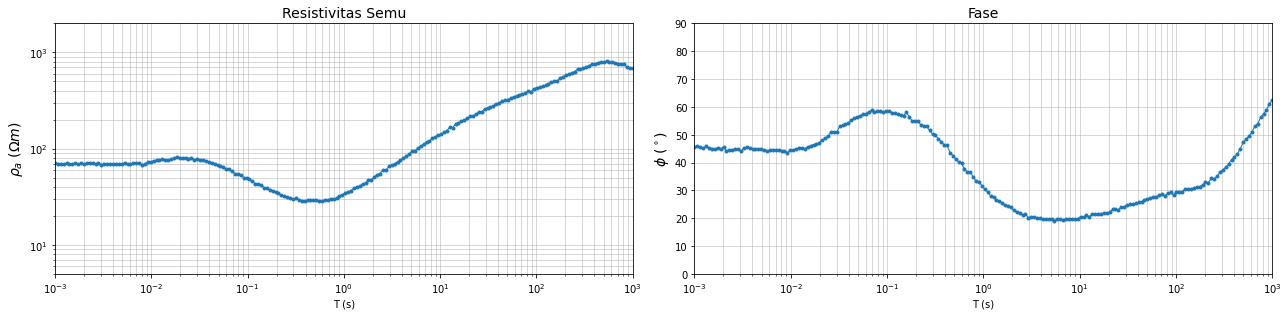

In [ ]:
loc_file = '/content/gdrive/MyDrive/ANN MT 1D/Data/data_1.csv' # Lokasi data
periods, rho, phi = open_data(loc_file)

# Reverse index array
periods = periods[::-1]
rho = rho[::-1]
phi = phi[::-1]

plot_data(periods, rho, phi, '.-')

In [ ]:
window_size = 5
batch_size = 100
shuffle_buffer_size = 100

In [ ]:
rho_forecast = model_forecast(rho_model, rho)
phi_forecast = model_forecast(phi_model, phi)

layers_tops = np.r_[0, -500, -750, -2250]
rho_layers = np.r_[70, 8, 60, 250]
frequency = np.logspace(-3, 3, 200)
max_depth_core = 4000
mesh, survey = build_mesh(frequency, max_depth_core)
z, rho_0 = model_int(mesh, survey, layers_tops, rho_layers)

>> Smallest cell size = 1 m
>> Padding distance = 316227 m
>> # of padding cells 28
>> # of core cells cells 285


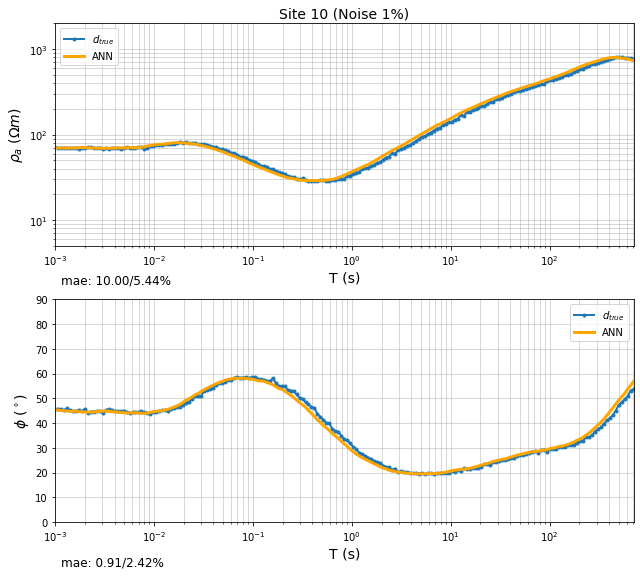

In [ ]:
fig1 = fitting(periods, rho, rho_forecast, phi, phi_forecast, "Site 10 (Noise 1%)")

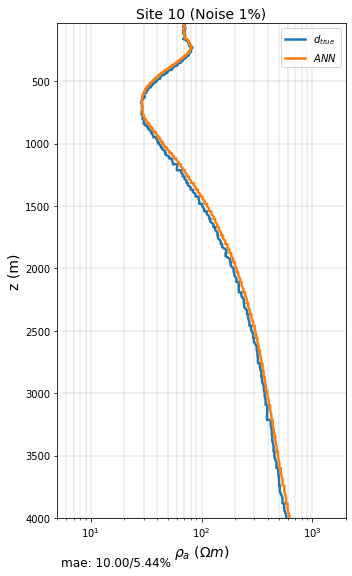

In [ ]:
fig2 = inv(z, max_depth_core, rho_0, rho, rho_forecast, "Site 10 (Noise 1%)", loglog=False)

In [ ]:
fig1.savefig('Fitting1.png')
fig2.savefig('Inversi1.png')